### Importing libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm 
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

Model 1 was an enocoder- decoder model. where enocder is used to extract the image features and decoder is used to generate the corresponding medical report.

Here we extract the image features using CheXNet model itself.
Now,instead of giving this features directly to the decoder model we perform some attention mechanism on the image features. Now, to the decoder, we give the context vector we obtained after attention which contains the relative importance of image regions. So based on this context vector the decoder generate the most apppropriate word.

## CheXnet Model

In model 1 the output required from the chexnet model was a flattened vector of sie 1048. So we used pooling ="avg". This will create a global average pooling layer as the final layer. Here we need the tensor without flattening. So we do not use global average pooling. So the final output (before softmax) we get will be of size 7,7,1024

In [51]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape)
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet.h5")

# chexnet_model.summary()

We have loaded the pre-trained chexnet model. Now we don't need the whole model. So we remove the last layer, and we take the output from the second last layer and consider it as the image features

In [52]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")    

### Read the data containing image paths and reports

In [53]:
#first we split the data set into train and test data sets
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv") 

In [54]:
leng=[]
for rep in train["report"]:
  leng.append(len(rep.split()))

print("90th percentile is ",np.percentile(leng,90))
print("99th percentile is ",np.percentile(leng,99))
print("max length is ",np.max(leng))


90th percentile is  41.0
99th percentile is  66.0
max length is  135


So we consider the maximum length for padding as 80 

In [55]:
# test.to_csv("test")
# train.to_csv("train")

In [56]:
def image_feature_extraction_n(image1, image2):
    image_1 = Image.open(image1)
    image_1 = np.asarray(image_1.convert("RGB"))

    image_2 = Image.open(image2)
    image_2 = np.asarray(image_2.convert("RGB"))

    # normalize the values of the image
    image_1 = image_1 / 255
    image_2 = image_2 / 255

    # resize all image into (224, 224)
    image_1 = cv2.resize(image_1, (224, 224))
    image_2 = cv2.resize(image_2, (224, 224))

    image_1 = np.expand_dims(image_1, axis=0)
    image_2 = np.expand_dims(image_2, axis=0)

    # now we have read two images per patient. These are given to the chexnet model for feature extraction
    image_1_out = final_chexnet_model(image_1)
    image_2_out = final_chexnet_model(image_2)

    # concatenate along the width
    conc = np.concatenate((image_1_out, image_2_out), axis=2)

    # reshape into (no. of images passed, length * breadth * depth)
    image_feature = tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))

    # reshape for attention mechanism
    
    # image_feature_reshaped = tf.reshape(image_feature, (image_feature.shape[0], -1, image_feature.shape[-1]))
    image_feature_reshaped = tf.reshape(image_feature, (image_feature.shape[0], -1, 2048))

    return image_feature_reshaped


In [89]:
def image_feature_extraction(image1, image2):
    image_1 = Image.open(image1)
    image_1 = np.asarray(image_1.convert("RGB"))

    image_2 = Image.open(image2)
    image_2 = np.asarray(image_2.convert("RGB"))

    # normalize the values of the image
    image_1 = image_1 / 255
    image_2 = image_2 / 255

    # resize all image into (224, 224)
    image_1 = cv2.resize(image_1, (224, 224))
    image_2 = cv2.resize(image_2, (224, 224))

    image_1 = np.expand_dims(image_1, axis=0)
    image_2 = np.expand_dims(image_2, axis=0)

    # now we have read two images per patient. These are given to the chexnet model for feature extraction
    image_1_out = final_chexnet_model(image_1)
    image_2_out = final_chexnet_model(image_2)

    # concatenate along the width
    conc = np.concatenate((image_1_out, image_2_out), axis=2)

    # reshape into (no. of images passed, length * breadth * depth)
    image_feature = tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))

    # reshape for attention mechanism
    
    image_feature_reshaped = tf.reshape(image_feature, (image_feature.shape[0], -1, image_feature.shape[-1]))
    # image_feature_reshaped = tf.reshape(image_feature, (image_feature.shape[0], -1, 2048))

    return image_feature_reshaped


Image Feature Extraction

In [58]:
# train_features=np.zeros((3056,98,1024))
# test_features=np.zeros((764,98,1024))

# for row in tqdm(range(train.shape[0])):
#   image_1=train.iloc[row]["image1"]
#   image_2=train.iloc[row]["image2"]
#   train_features[row]=(image_feature_extraction(image_1,image_2))


In [59]:
# data = pd.read_csv('data.csv')
# for row in tqdm(range(test.shape[0])):
#   image_1=data.iloc[row]["image1"] 
#   image_2=data.iloc[row]["image2"]
  # test_features[row]=(image_feature_extraction(image_1,image_2)) 

In [60]:
# np.save("train_features_attention",train_features)
# np.save("test_features_attention",test_features)

In [63]:
train_features=np.load("train_image_features.npy")
test_features=np.load("test_image_features.npy")  

In [64]:
train_features.shape

(3056, 1, 2048)

In [65]:
k=190
print(test_features[k])
one=test.iloc[k]["image1"] 
two=test.iloc[k]["image2"]
print(image_feature_extraction(one,two))   


[[3.6337416e-04 1.9040202e-03 1.4784778e-03 ... 7.8276551e-01
  8.6139482e-01 6.4804822e-01]]
tf.Tensor(
[[[0.0000000e+00 3.7009045e-03 1.0574656e-04 ... 0.0000000e+00
   9.1349643e-01 0.0000000e+00]
  [0.0000000e+00 3.0365409e-03 4.7063818e-03 ... 0.0000000e+00
   9.1831446e-01 0.0000000e+00]
  [0.0000000e+00 2.9123861e-03 8.7651022e-04 ... 0.0000000e+00
   9.1714954e-01 0.0000000e+00]
  ...
  [0.0000000e+00 2.8989550e-03 5.2299013e-04 ... 0.0000000e+00
   9.3059444e-01 0.0000000e+00]
  [0.0000000e+00 1.9310905e-03 2.5712424e-03 ... 0.0000000e+00
   9.1933733e-01 0.0000000e+00]
  [0.0000000e+00 1.5367710e-03 1.9667652e-03 ... 0.0000000e+00
   9.0351230e-01 0.0000000e+00]]], shape=(1, 98, 1024), dtype=float32)


In [66]:
print(train_features.shape)
print(test_features.shape) 

(3056, 1, 2048)
(764, 1, 2048)


In [67]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["report"].values]
train_report_in=["<sos> "+text for text in train["report"].values]
train_report_out=[text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]
test_report_in=["<sos> " +text for text in test["report"].values]
test_report_out=[text+" <eos>" for text in test["report"].values]  

In [68]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])


<sos> the heart normal size. the mediastinum unremarkable. the lungs are hypoinflated but grossly clear. 
****************************************************************************************************
the heart normal size. the mediastinum unremarkable. the lungs are hypoinflated but grossly clear.  <eos>


In [69]:
bs=10
max_len=80

In [70]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [71]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_padded_inp,train_padded_out)).shuffle(500)
train_dataset = train_dataset.batch(bs, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_padded_inp,test_padded_out)).shuffle(500)
test_dataset = test_dataset.batch(bs,drop_remainder=True) 


In [72]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(10, 1, 2048), dtype=tf.float32, name=None), TensorSpec(shape=(10, 80), dtype=tf.int32, name=None), TensorSpec(shape=(10, 80), dtype=tf.int32, name=None))>

In [73]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 


Done


100%|██████████| 2040/2040 [00:00<00:00, 50205.84it/s]


### Model with attention

1. We extract image features from feature extraction module

2. Now we pass this to encoder model which gives the encoder outputs

3. For the decoder model,


*   First we pass the decoder hidden state and encoder output to the attention model which calculate the attention weights
*   Now using the attention weights and encoder output we calculate the context vector

*   Now we take the context vector and embedding vector of decoder input and conncatenate this to a vector
*   Now we take this concatenated vector and pass it to the Bidirectional gru

*   Then the gru output is passed to the final dense layer








In [96]:
enc_units=64
embedding_dim=300
dec_units=64
att_units=64

In [97]:
input_img=Input(shape=(98,1024),name="image_fetaures")
# input_img=Input(shape=(98,1024),name="image_fetaures")
# input_img=Input(shape=(None,1,1024),name="image_fetaures")
input_txt=Input(shape=(max_len),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.5)(en_out)

state1= Input(shape=(bs,enc_units),name="state1")
state2= Input(shape=(bs,enc_units),name="state2")
state_h=tf.keras.layers.Add()([state1,state2])
#decoder model with attention

emb_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_b=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),emb_out],axis=1)
gru_out,state_1,state_2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(dec_units,return_sequences=True, return_state=True,name="Bidirectional_GRU"))(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense")(gru_out)
en_de=Model(inputs=[input_txt,input_img,state1,state2],outputs=out)

# keras.utils.plot_model(en_de)

In [98]:
#encoder model
'''
here the input will be image features with size (96,1024). We can consider this tensor as the encoder output.
But here we add another dense layer that will reduce the depth of this feature from 1024 to a low value
'''

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    # self.dense1=Dense(self.units,activation="relu",name="encoder_dense")
    self.dense1=Dense(2048,activation="relu",name="encoder_dense")
      
       
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self, input_):
        try:
            enc_out = self.maxpool(input_)
            enc_out = self.dense1(enc_out)
            return enc_out
        except Exception as e:
            raise ValueError(f"Error in Encoder layer with input shape {input_.shape}: {str(e)}")
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state
      If batch size is 32- Hidden state shape is [32,units]
      '''
      forward_h=tf.zeros((batch_size,self.units))
      back_h=tf.zeros((batch_size,self.units))
      return forward_h,back_h


In [77]:
#encoder model
'''
here the input will be image features with size (96,1024). We can consider this tensor as the encoder output.
But here we add another dense layer that will reduce the depth of this feature from 1024 to a low value
'''

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",name="encoder_dense")
    # self.dense1=Dense(2048,activation="relu",name="encoder_dense")
      
       
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self, input_):
        try:
            enc_out = self.maxpool(input_)
            enc_out = self.dense1(enc_out)
            return enc_out
        except Exception as e:
            raise ValueError(f"Error in Encoder layer with input shape {input_.shape}: {str(e)}")
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state
      If batch size is 32- Hidden state shape is [32,units]
      '''
      forward_h=tf.zeros((batch_size,self.units))
      back_h=tf.zeros((batch_size,self.units))
      return forward_h,back_h


In [99]:
'''
this is the attention class. 
Here the input to the decoder and the gru hidden state at the pevious time step are given, and the context vector is calculated

This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model

Here conact function is used for calaculating the attention weights

'''

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    
    # print(x.shape)
    # print(encoder_output.shape)
      
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)

    # print("en",encoder_output.shape)
    # print("al",alphas.shape)
    
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
    # context_vector = alphas*encoder_output
    # print("c",context_vector.shape)


    return (context_vector,alphas)

In [79]:
'''
This class will perform the decoder task.
The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput 
at time step t.
This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model

'''

class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
  #def build(self,inp_shape):
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.dec_units,return_sequences=True, return_state=True))
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2")

  def call(self,input_to_decoder, encoder_output, for_h,bac_h):
    
    embed=self.embedding(input_to_decoder)
    state_h=tf.keras.layers.Add()([for_h,bac_h])
    

    context_vector,alpha=self.attention(state_h,encoder_output)
    context_vector=self.dense_2(context_vector)

    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,forward_h,back_h=self.gru(result,initial_state=[for_h,bac_h])
    out=tf.reshape(output,(-1,output.shape[-1]))

    out=tf.keras.layers.Dropout(0.5)(out)
    
    dense_op=self.dense(out)
    
    return dense_op,forward_h,back_h,alpha

In [30]:
'''
For every input sentence, each output word is generated using one step decoder. Each output word is stored using the final decoder model and the
final output sentence is returned

'''

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1,state_2):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,state_2,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1,state_2)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
    

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
        
  
    #Coompute the image features using feature extraction model and pass it to the encoder
    # This will give encoder ouput
   # Pass the decoder sequence,encoder_output,initial states to Decoder
    # return the decoder output

  
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h,back_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h,back_h)
      
        return output      

In [82]:
model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)

In [83]:
optimizer = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_ 

In [84]:


# model.compile(optimizer=optimizer,loss=custom_lossfunction)
model.compile(optimizer=optimizer,loss=custom_lossfunction)


In [ ]:
#enc and dec units was changed to 64
#moved to cpu----this removed the warning while loading the model
#concatenated the forward_h and backward_h instaed of adding them
#max len was changed to 50
#removed recurrent initializer,recurrent activation and dropout terms from bidir gru-------solved the nan issue!
#NOW TRY TO FIT WITH ENTIRE DATA------worked!
#ram also didn't crash

#NOW SLOWLY IMPROVING THE PARAMETERS--ONE BY ONE----enc unit,dec unit and attention units and maxlen
# changed maxlen from 50 to 80----worked!
#changed it to 100 and added drop out--checking---not good results
#check if results and average bleu score are good 
#changed the max len to 80 again,enc dec =64 ,att unit=32and bs=5 and check again---checking...



In [30]:
# red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2, min_lr=0.0001) 
# ckpt=tf.keras.callbacks.ModelCheckpoint("model2wts/ckpt",monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto')

In [33]:
#run this cell 
# model.fit([train_features[:3050],train_padded_inp[:3050]],train_padded_out[:3050],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]),
        #   batch_size=bs,epochs=15,callbacks=[red_lr,ckpt]) 


In [85]:
from tensorflow.keras.models import load_model
# Load the model with custom_objects parameter
model = load_model("model2wts/ckpt", custom_objects={"custom_lossfunction": custom_lossfunction,"Encoder": Encoder, "Decoder": Decoder})
# loaded_model = load_model("path/to/your/saved/model", custom_objects={"Encoder": Encoder, "Decoder": Decoder})

# Example of loading the model with custom_objects parameter
# loaded_model = tf.keras.models.load_model("model2wts/ckpt/saved_model.pb", custom_objects={"Attention": Attention})


In [37]:
model.layers

[<__main__.Encoder at 0x2017fc98f50>, <__main__.Decoder at 0x201374b4b10>]

In [72]:
model.layers

[<__main__.Encoder at 0x235f3c708d0>, <__main__.Decoder at 0x235f3ca6950>]

In [73]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  131136    
                                                                 
 decoder (Decoder)           multiple                  1159218   
                                                                 
Total params: 1290354 (4.92 MB)
Trainable params: 1290354 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
def take_second(elem):
    return elem[1]

In [102]:

def beam_search(image1,image2, beam_index):

    hidden_state =  tf.zeros((1, enc_units))
    hidden_state2 =  tf.zeros((1, enc_units))
    # image_features=image_feature_extraction_n(image1,image2)
    image_features=image_feature_extraction_n(image1,image2)

    encoder_out = model.layers[0](image_features)
    # encoder_out = model.layers

    start_token = [token.word_index["<sos>"]]
    dec_word = [[start_token, 0.0]]
    while len(dec_word[0][0]) < max_len:
        temp = []
        for word in dec_word:
            
            predict, hidden_state,hidden_state2,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state,hidden_state2)
           
           
            word_predict = np.argsort(predict[0])[-beam_index:]
            for i in word_predict:

                next_word, probab = word[0][:], word[1]
                next_word.append(i)
                probab += predict[0][i] 
                temp.append([next_word, probab.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        
        
        dec_word = sorted(dec_word, key=take_second)
       
        # Getting the top words
        dec_word = dec_word[-beam_index:] 
        
     
    final = dec_word[-1]
    
    report =final[0]
    score = final[1]
    temp = []
    
    for word in report:
      if word!=0:
        if word != token.word_index['<eos>']:
            temp.append(token.index_word[word])
        else:
            break 

    rep = ' '.join(e for e in temp)        
    
    return rep, score

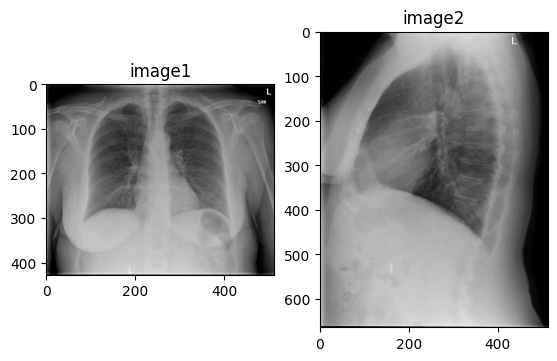

ACTUAL REPORT:  <sos> overall low lung volumes with mild patchy bibasilar airspace disease. this most represents atelectasis given the low lung volumes. pleural effusions pneumothoraces. heart and mediastinum normal size and contour.  <eos>
GENERATED REPORT:  <sos> the lungs are within normal right hemidiaphragm
BLEU SCORE IS:  1.4097034298540582e-231
time required for the evaluation is  10.00119137763977


In [103]:
data = pd.read_csv('data.csv')
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=data.iloc[i]["image1"]
img2=data.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start)     


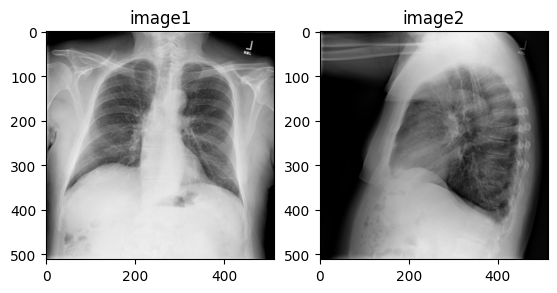

ACTUAL REPORT:  <sos> the heart normal size and contour. there mild calcification the transverse . the lungs are clear without evidence infiltrate. there pneumothorax effusion. degenerative changes the midthoracic spine are noted.  <eos>
GENERATED REPORT:  <sos> the lungs are within normal right hemidiaphragm
BLEU SCORE IS:  1.4097034298540582e-231
time required for the evaluation is  9.773359298706055


In [47]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
len(result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start)     


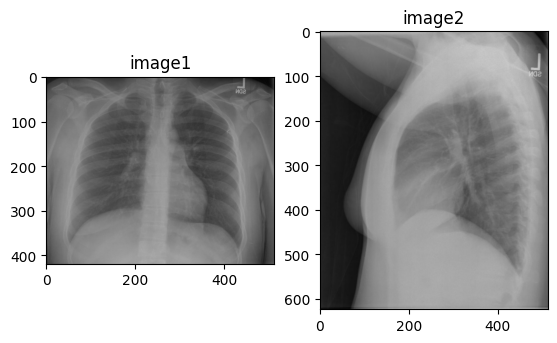

Image Features Shape: (1, 49, 2048)
ACTUAL REPORT:  <sos> frontal and lateral views the chest with overlying external cardiac monitor leads show unchanged cardiomediastinal silhouette. cardiac silhouette the upper limits normal size. tortuous ectatic aorta. the aortic near diameter. there retrocardiac left paraspinal bulge concerning for descending thoracic aortic aneurysm. there biapical scarring. focal airspace consolidation pleural effusion. spine spondylitic changes.  <eos>
GENERATED REPORT:  <sos> the mediastinum are within the lungs are large pleural effusion.
BLEU SCORE IS:  1.3483065280626046e-231
time required for the evaluation is  13.913013219833374


In [44]:
import random 
start=time.time()
i=100
img1=data.iloc[i]["image1"]
img2=data.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start) 


**OBSERVATION FROM THE ABOVE PREDICTION**

Here the actual report is about lungs. But the generated report is about mediastinum, which is near to lungs.
We can see for the above x-ray image, the previous model( beam+attention+gru) prediction didnt include "focal airspace disease" and this is recalled using this model. The bleu score for this report was increased from 0.69 to 0.74

The sentence structure is better than previous model

In [54]:
#compute average bleu score for test data
index=range(0,test.shape[0])
bl=0
start1=time.time()
for i in tqdm(index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result,sore=beam_search(img1,img2,3) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)
end1=time.time()
print("\n")
print("average bleu score on the test data is ",bl/test.shape[0])



  1%|          | 6/764 [01:13<2:35:02, 12.27s/it]


KeyboardInterrupt: 

In [ ]:
print("the average time for evaluating the attention model with beam search using bidirectinal GRU is ", (end1-start1)/764,"seconds")

the average time for evaluating the attention model with beam search using bidirectinal GRU is  5.068260778931423 seconds


**OBSERVATIONS:** This model  gave good results as compared to other models

In this approach we used the same paramters as in the attention+beam search model. The GRU is replaced with a bidirectional GRu and prediction of the reports was done using the beam search algorithm. 

The bleu score was slightly improved

The convergence was also faster when compared to the previous models

**LIMITATIONS**

Still the structure of the sentence is not really good in some cases

Also most frequent words are appearing in all senetences even wwhen those words are not there in the actual reoport

All these drawbacks might be due to the lack of data